# ML Term Paper - Code: Models
by Ann-Christin and Sarah 15/02/2021

In [54]:
# import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn import tree as tree

#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
import os
path = "C:/Users/gust/Documents/ML_term_paper"  # specify your path here
os.chdir(path)
data = pd.read_csv("Data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

C:\Users\gust\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,5,12,18,23,25,26,29,31,32,39,48,51,58,59,60,63,64,66,69,76,85,86,87,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(230691, 130)

In [3]:
data.head()


,Unnamed: 0,cntry,cntry_e,inpiaac,seqid,cnt_brth,ageg10lfs,age_r,gender_r,j_q03b,...,nfe12jr,nfe12njr,fnfaet12,fnfaet12jr,fnfaet12njr,nfehrsnjr,nfehrsjr,nfehrs,nopaidworkever,unempflag
0,0,USA,USA,1.0,9355.0,NaN,NaN,NaN,Male,NaN,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
1,1,USA,USA,1.0,10882.0,NaN,NaN,NaN,Male,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,30.0,30.0,Has had paid work,0.0
2,2,USA,USA,1.0,12329.0,NaN,NaN,NaN,Female,NaN,...,Did not participate in NFE for JR reasons,Did not participate in NFE for NJR reasons,Did not participate in formal or non-formal AET,Did not participate in formal or non-formal AE...,Did not participate in formal or non-formal AE...,NaN,NaN,NaN,Has had paid work,0.0
3,3,USA,USA,1.0,10711.0,NaN,NaN,NaN,Female,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,NaN,NaN,8.0,Has had paid work,0.0
4,4,USA,USA,1.0,10383.0,NaN,NaN,NaN,Male,NaN,...,Participated in NFE for JR reasons,Did not participate in NFE for NJR reasons,Participated in formal and/or non-formal AET,Participated in formal or non-formal AET for J...,Did not participate in formal or non-formal AE...,0.0,80.0,80.0,Has had paid work,0.0


In [4]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0', 'cntry', 'cntry_e', 'inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c", "isco1c", "c_d09", "isic1l", "cnt_h", "isced_hf", "isco1l", "isco1c", "c_d05"])
#"isic2l", "isic2c", "isic_cus_c", "isic_lus_c", "isic4_c", "isic4_l",
dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]
#drop if skill level is missing 
#dcl = dcl[dcl.iscoskil4 != "A"]
#dcl = dcl[dcl.iscoskil4 != "N"]
#dcl = dcl[dcl.iscoskil4 != "U"]

In [5]:
#thresh = len(dcl) * .18
#dcl.dropna(thresh = thresh, axis = 1, inplace = True)
#dcl.info()

In [6]:
cate = dcl.select_dtypes(include=['object'])
cate = cate.drop(columns = ["iscoskil4"]) 
cate = list(set(cate))
cate

['b_q11',
 'nfe12',
 'd_q06b',
 'b_q15b',
 'g_q05d',
 'd_q04',
 'g_q07',
 'd_q04_t',
 'isic1c',
 'g_q05g',
 'f_q07a',
 'b_q12g',
 'b_q01b',
 'd_q13c',
 'edcat8',
 'g_q05h',
 'd_q14',
 'fnfaet12jr',
 'nfe12jr',
 'b_q02a_t1',
 'b_q14a',
 'b_q15a',
 'b_q13',
 'c_d06',
 'g_q05c',
 'b_q12e',
 'cnt_brth',
 'b_q16',
 'vet',
 'b_q14b',
 'g_q05a',
 'fnfaet12',
 'b_q12a',
 'b_q20b',
 'g_q05f',
 'g_q04',
 'b_q02a_t2',
 'd_q06c',
 'g_q05e',
 'b_q02a',
 'nopaidworkever',
 'c_q02a',
 'd_q03',
 'fe12',
 'b_q10b',
 'b_q04a',
 'b_q05c',
 'b_q10c',
 'fnfaet12njr',
 'leaver1624',
 'g_q06',
 'd_q09',
 'aetpop',
 'b_d12h',
 'b_q01a',
 'j_q04a',
 'b_q26b',
 'd_q07a',
 'ageg10lfs',
 'faet12jr',
 'pared',
 'nfe12njr',
 'b_q01a_t',
 'd_q12a',
 'd_q06a',
 'f_q07b',
 'faet12',
 'd_q12b',
 'b_q12c',
 'b_q15c',
 'd_q12c',
 'b_q26a_t',
 'gender_r',
 'b_q10a',
 'faet12njr',
 'computerexperience',
 'g_q08']

In [7]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1 = pd.DataFrame(dummies1)
dummies2 = dummies2.pop(0)
dummies2 = pd.DataFrame(dummies2)
dummies = dummies1.join(dummies2)
dummies = dummies.drop(columns = ["skill_4"])
dummies.head()
dummies.info()          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 417 entries, b_q11_No, not at all to skill_U
dtypes: uint8(417)
memory usage: 91.7 MB


In [8]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [9]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsqual        218593 non-null  float64
 3   yrsget         125736 non-null  float64
 4   c_q09          160575 non-null  float64
 5   c_q10a         147420 non-null  float64
 6   d_q05a2        94539 non-null   float64
 7   d_q16b         71135 non-null   float64
 8   readytolearn   226734 non-null  float64
 9   icthome        171755 non-null  float64
 10  ictwork        102478 non-null  float64
 11  earnmthallppp  88508 non-null   float64
dtypes: float64(12)
memory usage: 21.1 MB


In [10]:
num_list = list(set(num))
num_list

['age_r',
 'earnmthallppp',
 'j_q03b',
 'c_q09',
 'c_q10a',
 'yrsqual',
 'd_q05a2',
 'readytolearn',
 'icthome',
 'ictwork',
 'd_q16b',
 'yrsget']

In [11]:
# define X and y
on_job = dcl["b_q12d"] #define y here
open_educ = dcl["b_q12b"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
y = pd.DataFrame(dict(on_job=on_job, open_educ =open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsqual,yrsget,c_q09,c_q10a,d_q05a2,d_q16b,...,b_q10a_Yes,faet12njr_Participated in FE for NJR reasons,computerexperience_Yes,g_q08_Yes,skill_1,skill_2,skill_3,skill_A,skill_N,skill_U
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,NaN,NaN,NaN,NaN,19.0,19.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,NaN,NaN,NaN,NaN,8.0,8.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
230687,NaN,NaN,NaN,NaN,11.0,11.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
230688,NaN,NaN,NaN,NaN,12.0,11.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
230689,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
on_job.describe()

count    46750.000000
mean         3.252021
std          4.441589
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         50.000000
Name: b_q12d, dtype: float64

In [13]:
open_educ.describe()

count    16053.000000
mean         2.517660
std          3.785557
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         50.000000
Name: b_q12b, dtype: float64

## OLS

In [14]:
# run OLS on job
import statsmodels.api as sm

nona = y_X.drop(columns = ["open_educ"])
nona = nona.dropna()
y = nona["on_job"]
X = nona.iloc[:, 1:]

est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\gust\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 on_job   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     5.025
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          3.03e-162
Time:                        13:19:10   Log-Likelihood:                -30289.
No. Observations:               10903   AIC:                         6.125e+04
Df Residuals:                   10565   BIC:                         6.372e+04
Df Model:                         337                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
age_r                                                                                          -0.0183      0.016     -1.131      0.258      -0.050       0.013
j_q03b                                                                                         -0.0050      0.045     -0.111      0.911      -0.092       0.082
yrsqual                                                                                        -0.1812      0.064     -2.834      0.005      -0.307      -0.056
yrsget                                                                                          0.0548      0.058      0.938      0.348      -0.060       0.169
c_q09                                                                                           0.0270      0.009      3.031      0.002       0.010       0.044
c_q10a                                                                                          0.0747      0.037      2.016      0.044       0.002       0.147
d_q05a2                                                                                         0.0044      0.005      0.869      0.385      -0.006       0.014
d_q16b                                                                                      -1.761e-09   6.92e-09     -0.255      0.799   -1.53e-08    1.18e-08
readytolearn                                                                                    0.1509      0.048      3.147      0.002       0.057       0.245
icthome                                                                                         0.0069      0.054      0.129      0.898      -0.098       0.112
ictwork                                                                                         0.1002      0.154      0.652      0.515      -0.201       0.402
earnmthallppp                                                                                3.613e-07   2.52e-06      0.143      0.886   -4.58e-06    5.31e-06
b_q11_No, not at all                                                                            0.2192      0.639      0.343      0.732      -1.034       1.473
b_q11_There were no such costs                                                                 -0.3454      0.824     -0.419      0.675      -1.960       1.269
b_q11_Yes, partly                                                                              -0.1690      0.707     -0.239      0.811      -1.555       1.217
b_q11_Yes, totally                                                                              1.2010      0.658      1.826      0.068      -0.088       2.490
nfe12_Participated in NFE                  

In [ ]:
# run OLS open educ
import statsmodels.api as sm
y = nona["open_educ"]
X = nona.iloc[:, 2:]

est = sm.OLS(y, X, missing='drop').fit()
X = sm.add_constant(X)
est.summary()

## Feature selection with Benjamini - Hochberg Algorithm

In [27]:
# FDR selection:  Benjamini - Hochberg as a first attempt to regularise the model

from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.model_selection import train_test_split

y = nona["on_job"]
X = nona.iloc[:, 1:]

# ! it is more correct to perform FDR only on the train data, therefore it is inside the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.1)),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train)) #In sample fit decreases afte throughing out variables
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test)) # Out of sample fit did not increase by much

In-sample Rsq:  0.1218
Out-of-sample Rsq:  0.0872


C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\gust\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:675: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\skl

In [30]:
# Use K-fold out-of-sample validation to compare the predictive power of the full and of the reduced model
from sklearn.model_selection import KFold, cross_val_score

y = nona["on_job"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=3, shuffle=True, random_state=1) # we use five splits, randam_state makes sure we can replacte the data (get same random numbers)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_full = cross_val_score(pipe, X, y, cv=kf)
print("scores full")
print(scores_full)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_full.mean(), scores_full.std() * 2))

scores full
[-3.08860815e+22 -9.24693321e+22 -2.25633217e+23]
Accuracy: -116329543466439118159872.00000 (+/- 162551275591443459080192.00000)


In [31]:
y = nona["on_job"]
X = nona.iloc[:, 1:]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('fdr', SelectFdr(f_regression, alpha=0.05)),
                 ('regr', LinearRegression(fit_intercept = True, normalize=False, copy_X=False, n_jobs=-1))])
scores_reduced = cross_val_score(pipe, X, y, cv=kf)
print("scores_reduced")
print(scores_reduced)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores_reduced.mean(), scores_reduced.std() * 2))

C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\gust\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:675: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\skl

scores_reduced
[0.08425157 0.08355887 0.10739366 0.03320599 0.06964276]
Accuracy: 0.07561 (+/- 0.04884)


C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\gust\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:675: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()
C:\Users\gust\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
  selected = sv[sv <= float(self.alpha) / n_features *
C:\Users\gust\Anaconda3\lib\site-packages\skl

Text(0.5, 1.0, 'Out-of-sample validation')

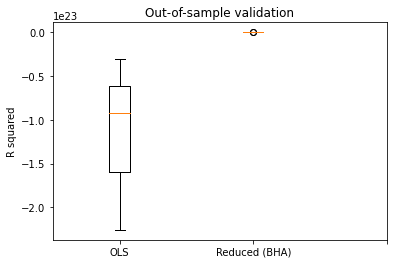

In [34]:
fig, ax = plt.subplots()
ax.boxplot([scores_full, scores_reduced])
plt.xticks([1, 2, 3], ['OLS', 'Reduced (BHA)'])
plt.ylabel('R squared')
plt.title('Out-of-sample validation')

## Lasso

In [42]:
# Use K-fold out-of-sample validation to select the 'best' $\lambda$. Plot average out-of-sample error as a function of $\lambda$. 
# Note: can take some time
from sklearn.linear_model import LassoCV
import time

y = nona["on_job"]
X = nona.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=0.005, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.1412
Out-of-sample Rsq:  0.0695


Computing regularization path using the lasso...
Ready


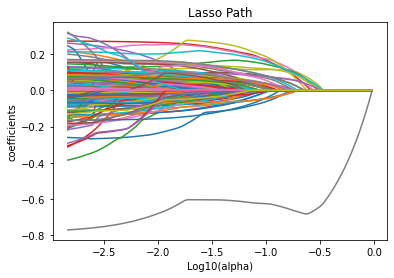

In [43]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000, fit_intercept=True)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.show()

In [44]:
from sklearn.linear_model import LassoCV
import time

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lassocv', LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))])

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0032 
Training time =  10.9528s 


In [45]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lasso', 
                  Lasso(alpha=l.alpha_, fit_intercept=True, normalize=False, copy_X=False, max_iter=10000))])
# note alpha == lambda in the lecture notes; we just take some value - it is not the optimal! 
# again if you simply follow the defaults, it is not necessary to specify the options
pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

In-sample Rsq:  0.1422
Out-of-sample Rsq:  0.0679


In [46]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-2.65164929e-01, -1.08611597e-03, -3.12631307e-01,  1.23024626e-01,
        2.39226824e-01,  2.83820219e-02,  7.24639257e-02, -1.15192574e-02,
        1.20323557e-01,  3.55097119e-03,  9.61815231e-02,  3.57258737e-03,
        1.56442888e-02, -3.94274916e-02, -5.67320144e-02,  8.29652022e-02,
        0.00000000e+00,  4.73870449e-02, -2.02716890e-02,  0.00000000e+00,
       -1.35069326e-02, -6.60518677e-02,  3.81602642e-02, -3.45545145e-02,
        1.04708126e-03,  5.61823564e-02,  0.00000000e+00, -2.37385678e-02,
        5.30888716e-03,  1.57338848e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.07740863e-02, -1.71440899e-02,
       -2.55393540e-02, -1.91342003e-02, -1.70712127e-02, -3.22775392e-02,
       -3.33505419e-02,  5.97265164e-03,  0.00000000e+00,  4.46880851e-02,
       -4.11615245e-02, -1.40369276e-02,  0.00000000e+00,  1.26082832e-01,
        3.82921007e-03, -2.03784595e-02,  5.78472735e-02, -6.32631652e-03,
        1.34357061e-02,  

In [47]:
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,-0.265165,age_r
1,-0.001086,j_q03b
2,-0.312631,yrsqual
3,0.123025,yrsget
4,0.239227,c_q09
...,...,...
424,-0.228169,skill_2
425,-0.000000,skill_3
426,0.000000,skill_A
427,0.076497,skill_N


In [48]:
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

,Lasso coefficient,Feature
0,-0.265165,age_r
1,-0.001086,j_q03b
2,-0.312631,yrsqual
3,0.123025,yrsget
4,0.239227,c_q09
...,...,...
422,0.073594,g_q08_Yes
423,-0.231553,skill_1
424,-0.228169,skill_2
427,0.076497,skill_N


# Random Forest 

In [51]:

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.096
Out-of-sample MSE: 21.000


In [52]:
# we can check whether we had enough trees in the forest
# Use cross-validation to determine the optimal number of trees

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

In [53]:
result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X_train, y_train)

matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 50 trees. 

NameError: name 'cross_validate' is not defined

In [55]:
# feature importance

imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'